In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import accuracy_score
from transformers import BertTokenizer, BertModel, AdamW
from torch.optim.lr_scheduler import StepLR


**Preparing train dataset**

In [2]:
newtrainData = pd.read_csv('finalDataset.csv', encoding='ISO-8859-1')
newtrainData = newtrainData.dropna(subset=['cleaned_text', 'sentiment'])

**One-hot encoding of `sentiment` column**

In [3]:
sentiment_enc = pd.get_dummies(newtrainData['sentiment'], dtype=int)
newtrainData['sentiment'] = sentiment_enc.values.tolist()

<ipython-input-3-68b1ff8e0fd0>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  newtrainData['sentiment'] = sentiment_enc.values.tolist()


In [19]:
newtrainData['sentiment'].value_counts()

,count
sentiment,
"[0, 1, 0]",11017
"[0, 0, 1]",8578
"[1, 0, 0]",7773


neutral, positive, negative

**Scaling numerical features: `Density` and `Land Area`**

In [4]:
numeric_columns = ['Density', 'Land Area']
scaler = StandardScaler()
scaled_numeric_data = scaler.fit_transform(newtrainData[numeric_columns])
newtrainData[numeric_columns] = scaled_numeric_data

In [5]:
class CustomDataset(Dataset):
    def __init__(self, data, tokenizer, max_length=128):
        self.texts = data['cleaned_text'].tolist()
        self.numeric_features = data[['Density', 'Land Area']].values
        self.labels = data['sentiment'].values

        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        text = self.texts[idx]
        numeric_features = self.numeric_features[idx]
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'numeric_features': torch.tensor(numeric_features, dtype=torch.float),
            'label': torch.tensor(label, dtype=torch.long)
        }


In [6]:
class SentimentModel(nn.Module):
    def __init__(self, n_classes, n_num_features=2):
        super(SentimentModel, self).__init__()
        self.bert = BertModel.from_pretrained("bert-base-uncased")
        self.drop = nn.Dropout(p=0.5)

        # numerical features
        self.num_features_layer = nn.Linear(n_num_features, 32)

        # Final layer
        self.fc = nn.Linear(self.bert.config.hidden_size + 32, n_classes)

    def forward(self, input_ids, attention_mask, numeric_features):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        x1 = self.drop(pooled_output)

        # numerical features
        x2 = self.num_features_layer(numeric_features)
        x3 = torch.relu(x2)

        # Concatenate BERT with numerical features
        x4 = torch.cat((x1, x3), dim=1)
        y = self.fc(x4)

        return y

**Training the Model**

In [7]:
def train_model(model, data_loader, loss_fn, optimizer, device, num_epochs=10):
    model = model.to(device)
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        correct_predictions = 0
        total_predictions = 0

        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)

            numeric_features = batch['numeric_features'].to(device)

            labels = batch['label'].to(device)
            labels_indices = torch.argmax(labels, dim=1)

            optimizer.zero_grad()
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, numeric_features=numeric_features)
            loss = loss_fn(outputs, labels_indices)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

            # accuracy
            _, predicted = torch.max(outputs, dim=1)
            correct_predictions += (predicted == labels_indices).sum().item()
            total_predictions += labels_indices.size(0)

        avg_loss = total_loss / len(data_loader)
        epoch_accuracy = correct_predictions / total_predictions
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}, Accuracy: {epoch_accuracy * 100:.2f}%")


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
train_dataset = CustomDataset(newtrainData, tokenizer)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

model = SentimentModel(n_classes=3)
optimizer = AdamW(model.parameters(), lr=2e-5)
loss_fn = nn.CrossEntropyLoss()

# overfitting problem: freeze some BERT layers
for param in model.bert.encoder.layer[:6].parameters():
    param.requires_grad = False

train_model(model, train_loader, loss_fn, optimizer, device)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/10, Loss: 0.7988, Accuracy: 64.84%
Epoch 2/10, Loss: 0.6598, Accuracy: 73.23%
Epoch 3/10, Loss: 0.6069, Accuracy: 75.72%
Epoch 4/10, Loss: 0.5497, Accuracy: 78.20%
Epoch 5/10, Loss: 0.4935, Accuracy: 80.66%
Epoch 6/10, Loss: 0.4211, Accuracy: 84.04%
Epoch 7/10, Loss: 0.3525, Accuracy: 86.73%
Epoch 8/10, Loss: 0.2804, Accuracy: 89.60%
Epoch 9/10, Loss: 0.2273, Accuracy: 91.92%
Epoch 10/10, Loss: 0.1801, Accuracy: 93.49%


In [8]:
import os

save_directory = "/content"
save_filename = "model_10epoch.pth"
os.makedirs(save_directory, exist_ok=True)
save_path = os.path.join(save_directory, save_filename)
torch.save(model.state_dict(), save_path)

**SHAP values analysis**

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


  0%|          | 0/100 [00:00<?, ?it/s]

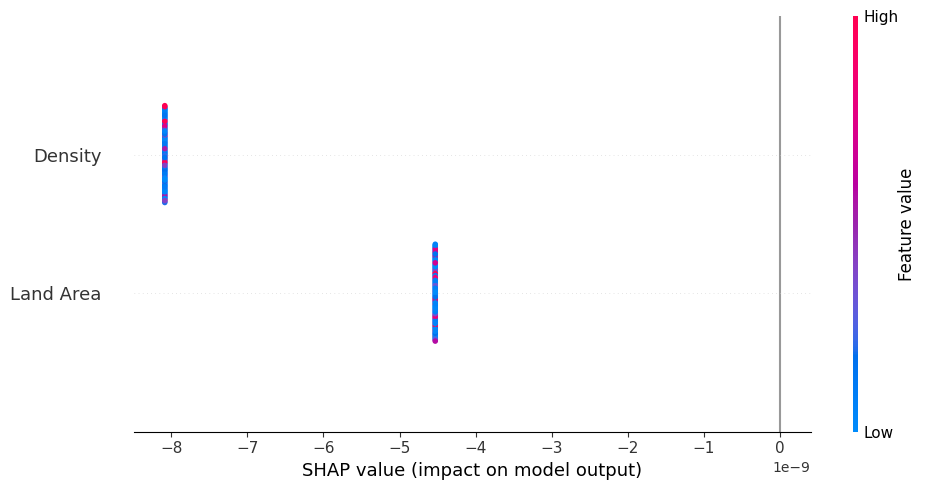

In [21]:
import torch
import shap
import numpy as np
from transformers import AutoTokenizer

# Initialize the tokenizer
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

# Sample data setup
sample_size = 100
sample_indices = np.random.choice(newtrainData.index, size=sample_size, replace=False)
sample_data = newtrainData.loc[sample_indices]

# Extract text and numeric features
texts = sample_data['cleaned_text'].tolist()
numeric_features = sample_data[['Land Area', 'Density']].values.astype(np.float32)

# Tokenize text data and convert to a fixed-length array
encoded_inputs = tokenizer(texts, padding='max_length', max_length=110, truncation=True, return_tensors="pt")
input_ids = encoded_inputs['input_ids']
attention_masks = encoded_inputs['attention_mask']

# Define the prediction function for SHAP
def predict_fn(text_inputs, numeric_inputs):
    model.eval()
    all_predictions = []

    with torch.no_grad():
        for i in range(text_inputs.shape[0]):
            input_id = text_inputs[i].unsqueeze(0).to(device)  # Shape (1, 110)
            attention_mask = attention_masks[i].unsqueeze(0).to(device)  # Shape (1, 110)

            # Convert numeric_inputs to tensor
            numeric_feature = torch.tensor(numeric_inputs[i], dtype=torch.float32).unsqueeze(0).to(device)  # Shape (1, 2)

            # Model prediction
            outputs = model(input_ids=input_id, attention_mask=attention_mask, numeric_features=numeric_feature)
            predictions = torch.softmax(outputs, dim=1).cpu().numpy()
            all_predictions.append(predictions)

    return np.vstack(all_predictions)

# Background data for SHAP (numeric features only)
background_data = numeric_features[:50]

# Create SHAP KernelExplainer
explainer = shap.KernelExplainer(lambda x: predict_fn(input_ids[:len(x)], numeric_features[:len(x)]), background_data)

# Compute SHAP values
shap_values = explainer.shap_values(numeric_features)
shap_values_avg = shap_values.mean(axis=2)
shap.summary_plot(shap_values_avg, features=numeric_features, feature_names=['Land Area', 'Density'], plot_size=(10, 5))

In [22]:
shap_values_class_0 = shap_values[:, :, 0]  # SHAP values for class 0
shap_values_class_1 = shap_values[:, :, 1]  # SHAP values for class 1
shap_values_class_2 = shap_values[:, :, 2]  # SHAP values for class 2

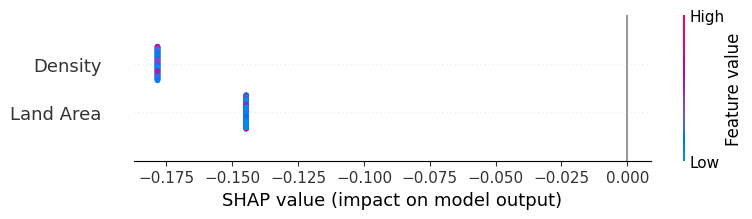

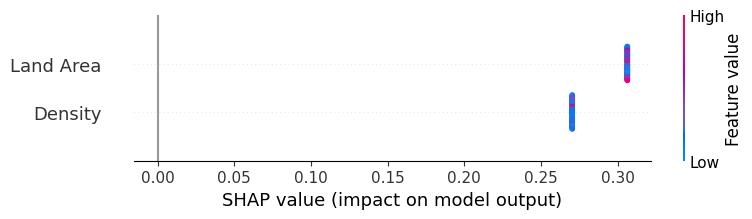

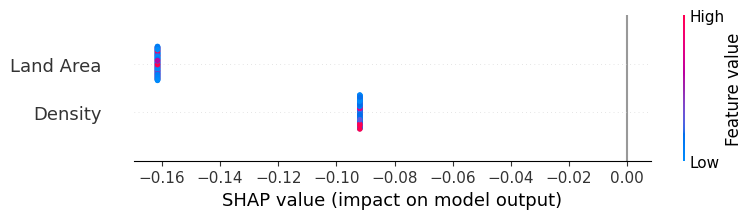

In [23]:
# Summary plot for class 0
shap.summary_plot(shap_values_class_0, features=numeric_features, feature_names=['Land Area', 'Density'])

# Summary plot for class 1
shap.summary_plot(shap_values_class_1, features=numeric_features, feature_names=['Land Area', 'Density'])

# Summary plot for class 2
shap.summary_plot(shap_values_class_2, features=numeric_features, feature_names=['Land Area', 'Density'])


**Preparing test dataset**

In [12]:
test_data = pd.read_csv('finalDatasetTest.csv', encoding='ISO-8859-1')
test_data = test_data.dropna(subset=['cleaned_text', 'sentiment'])

In [13]:
sentiment_enc = pd.get_dummies(test_data['sentiment'], dtype=int)
test_data['sentiment'] = sentiment_enc.values.tolist()

In [14]:
numeric_columns = ['Density', 'Land Area']
scaler = StandardScaler()
scaled_numeric_data = scaler.fit_transform(test_data[numeric_columns])
test_data[numeric_columns] = scaled_numeric_data

**Testing the Model**

In [15]:
def test_model(model, data_loader, loss_fn, device):
    model = model.to(device)
    model.eval()

    total_loss = 0
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            numeric_features = batch['numeric_features'].to(device)
            labels = batch['label'].to(device)
            labels_indices = torch.argmax(labels, dim=1)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, numeric_features=numeric_features)
            loss = loss_fn(outputs, labels_indices)
            total_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs, dim=1)
            correct_predictions += (predicted == labels_indices).sum().item()
            total_predictions += labels_indices.size(0)

    avg_loss = total_loss / len(data_loader)
    accuracy = correct_predictions / total_predictions
    print(f"Test Loss: {avg_loss:.4f}, Test Accuracy: {accuracy * 100:.2f}%")
    return avg_loss, accuracy


test_dataset = CustomDataset(test_data, tokenizer)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

test_loss, test_accuracy = test_model(model, test_loader, loss_fn, device)

Test Loss: 1.0527, Test Accuracy: 70.66%


**Plotting Confusion Matrix**

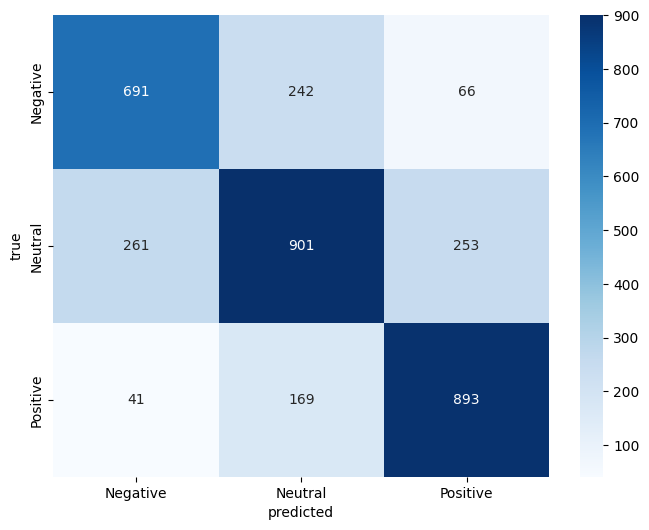

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_cm(model, data_loader, device):
    model.eval()
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            numeric_features = batch['numeric_features'].to(device)
            labels = batch['label'].to(device)
            labels_indices = torch.argmax(labels, dim=1)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, numeric_features=numeric_features)
            _, predicted = torch.max(outputs, dim=1)

            all_labels.extend(labels_indices.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    cm = confusion_matrix(all_labels, all_predictions)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
    plt.xlabel('predicted')
    plt.ylabel('true')
    plt.show()

plot_cm(model, test_loader, device)


Model Strengths: The model performs relatively well at identifying Neutral and Positive sentiments since these classes have the highest counts on the diagonal (943 for Neutral and 812 for Positive).
Areas for Improvement: There is notable confusion between Neutral and Negative, as seen by the 289 Neutral samples misclassified as Negative. The model also struggles somewhat with distinguishing Positive from Neutral (227 samples misclassified).